# 1. Setup

In [1]:
# %load ../jupyter_setup.txt
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False 

In [2]:
import os
import pathlib
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm.notebook

# Custom utils for rasterio
from src.data_loading.rasterio_utils import get_thumbnail, read_from_lat_lon
from src.data_loading.vector_utils import shapely_to_frame
from src.data_loading.landcover_plot_utils import classes_to_rgb
from src.utils import get_byte_size, get_osm_polygon

# Path to ESA Landcover datasets on Jasmin
from src.constants import ESA_LANDCOVER_DIR, GWS_DATA_DIR, WGS84, PREFERRED_CRS

# For loading geotiff data
import rioxarray as rxr
import rasterio
from rasterio.mask import mask
from rasterio.crs import CRS

# For loading and manipulating vector data
import geopandas as gpd
from shapely.geometry import box, Point
# For performing geospatial analysis
import pylandstats as pls

# For conveniently getting longitude, latitude from name (& geodesic distances)
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="fragmentation-analysis")
logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 2. Data loading

## 2.1 Chernobyl geographic data

Let us first load the location of the Chernobyl nuclear power plant, as well as the borders
of the exclusion zones in Chernobyl (Ukraine) and Polesie (Belarus) from Open Street map.

Note that the Open Street map coordinate system is WGS84, while we will later work in UTM 35,
to be able to locally express distances in meters.

In [3]:
nuclear_plant = geolocator.geocode("Chernobyl Nuclear Plant")
nuclear_plant = Point((nuclear_plant.longitude, nuclear_plant.latitude))

# Get exclusion zone boundaries for chernobyl (Ukraine)
chernobyl_zone_id = 3311547
chernobyl_exclusion_zone = gpd.read_file(get_osm_polygon(chernobyl_zone_id))  # in WGS 84
chernobyl_exclusion_zone.crs = WGS84  # set coorindate system to WGS 84
chernobyl_exclusion_zone["name"] = ["Chernobyl Exclusion Zone"]

# Get exclusion zone boundaries for polesie (Belarus)
polesie_zone_id = 3397849
polesie_exclusion_zone = gpd.read_file(get_osm_polygon(polesie_zone_id))  # in WGS 84
polesie_exclusion_zone.crs = WGS84  # set coorindate system to WGS 84
polesie_exclusion_zone["name"] = ["Polesie Exclusion Zone"]
# NOTE: 
# Potentially we want to create our own CRS with the power plant / exclusion zone 
#  centroid at its center, such that we can measure distances conveniently in meters
#  on the ground.

## 2.2 ESA CCI landcover data

We are using ESA CCI Landcover data from 1992 to 2015 with a ground resolution (GSD) of 
300m.

In [4]:
esa_cci_landcovers = {year: ESA_LANDCOVER_DIR / f"ESACCI-LC-L4-LCCS-Map-300m-P1Y-{year}-v2.0.7.tif" 
                      for year in range(1992, 2016)}

# Check that paths indeed exist
for path in esa_cci_landcovers.values():
    assert os.path.exists(path)
    
# Parse land cover classes:
landcover_classes = ESA_LANDCOVER_DIR / "ESACCI-LC-Legend.csv"
classes = pd.read_csv(landcover_classes, delimiter=";", index_col=0)

print(f"There are {len(classes)} classes.")
print(classes.head())

There are 38 classes.
                                 LCCOwnLabel    R    G    B
NB_LAB                                                     
0                                    No data    0    0    0
10                         Cropland, rainfed  255  255  100
11                          Herbaceous cover  255  255  100
12                       Tree or shrub cover  255  255    0
20      Cropland, irrigated or post-flooding  170  240  240


The ESA CCI dataset has 37 classes of landcover (+ 1 no data class). 

# 3. Experimental setup

In [5]:
## TO FILE:
from shapely.geometry.base import BaseGeometry
from typing import Union, List, Tuple, Iterable, Dict, Any

def shapely_to_frame(shapes: Union[BaseGeometry, Union[BaseGeometry]], 
                     attributes: Dict[str, Any] = {}, 
                     crs: str = None, 
                     **kwargs):       
    """Convenience function to turn shapely objects into geopandas dataframes"""
    
    is_multiple = isinstance(shapes, Iterable)
        
    data = {"geometry": shapes if is_multiple else [shapes]}
    for key, val in attributes.items():
        data[key] = val if is_multiple else [val]
        
    for key, val in kwargs.items():
        data[key] = val if is_multiple else [val]
    
    return gpd.GeoDataFrame(data, crs=crs)

## 3.1 Define regions of interest

Define regions of interest for later comparisons in the study:

1. Combination of the exlcusion zones (representing no human impact).
2. 30 km buffer around the exclusion zones (representing reduced human impact)
3. 60 km buffer around the exclusion zones (representing mostly normal human impact)

In [6]:
# Next closer ROI: 30km buffer around exclusion zones (reduced human activity)
buffer_size = 30 # in km (preferred CRS: UTM 35 is in m)

# Generate ROIs from exclusion zones: 
roi0 = shapely_to_frame(nuclear_plant, crs=WGS84, name="Nuclear Plant")
roi1 = chernobyl_exclusion_zone.append(polesie_exclusion_zone)

# Generate (exclusion_zone + buffer) and (exclusion_zone + 2*buffer) ROIs
roi3_outline = roi1.to_crs(PREFERRED_CRS).buffer(2*buffer_size*1e3).to_crs(WGS84).unary_union
roi2_outline = roi1.to_crs(PREFERRED_CRS).buffer(buffer_size*1e3).to_crs(WGS84).unary_union

roi3_shape = roi3_outline - roi2_outline
roi2_shape = roi2_outline - roi1.unary_union

roi3 = shapely_to_frame(roi3_shape, crs=WGS84, name=f"E+{2*buffer_size}")
roi2 = shapely_to_frame(roi2_shape, crs=WGS84, name=f"E+{buffer_size}")

# Get bounding box of all ROIs
bbox = shapely_to_frame(roi3_shape.envelope, crs=WGS84, name="bbox")

Let's add the regions of interest to one single data frame and caluclate their areas in km$^2$

In [7]:
# Calculate the areas
rois = bbox.append([roi3, roi2, roi1, roi0]).reset_index(drop=True)
rois["area (km2)"] = rois.to_crs(PREFERRED_CRS).area / 1e6
rois

,geometry,name,area (km2)
0,"POLYGON ((28.40773 50.54449, 31.41977 50.54449...",bbox,44022.318370
1,"POLYGON ((28.42221 51.16929, 28.42178 51.17077...",E+60,17608.538086
2,"POLYGON ((28.84467 51.21708, 28.84425 51.21856...",E+30,12731.935189
3,GEOMETRYCOLLECTION (MULTIPOLYGON (((29.26795 5...,Chernobyl Exclusion Zone,2597.858793
4,GEOMETRYCOLLECTION (MULTIPOLYGON (((29.46530 5...,Polesie Exclusion Zone,2216.675202
5,POINT (30.10410 51.38974),Nuclear Plant,0.000000


Note: The area in km2 for the Chernobyl exclusion zone matches with the quoted value on Wikipedia,
which is approx [2600 km2](https://en.wikipedia.org/wiki/Chernobyl_Exclusion_Zone).

In [8]:
get_byte_size(rois)

'14 KB'

Next, let's visualise our areas of interest on the map (WGS84 coordinates - latitude, longitude)

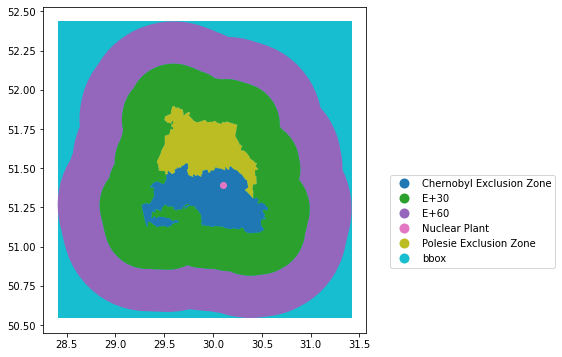

In [9]:
fig, ax = plt.subplots(figsize=(14, 6))

rois.to_crs(WGS84).plot(column="name", categorical=True, legend=True, ax=ax)
legend = ax.get_legend()
legend.set_bbox_to_anchor((1.6,0.5))

In [10]:
#rois.to_file(GWS_DATA_DIR / "chernobyl_exclusion_zone_v1.geojson", driver='GeoJSON')

## 3.2 Cut landcover datasets to regions of interest

Next, let us look at the region of the landcover data that we cut out for the 
sample case of 2015

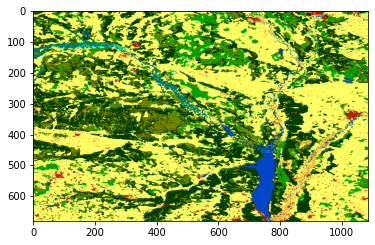

In [11]:
landcover_2015 = rasterio.open(esa_cci_landcovers[2015])

minx, miny, maxx, maxy = bbox.bounds.iloc[0].values
lat = (miny, maxy)
lon = (minx, maxx)

plt.imshow(classes_to_rgb(read_from_lat_lon(landcover_2015, 1, lat, lon)));

Ok, from a quick comparison to the map on OSM, this seems correct.

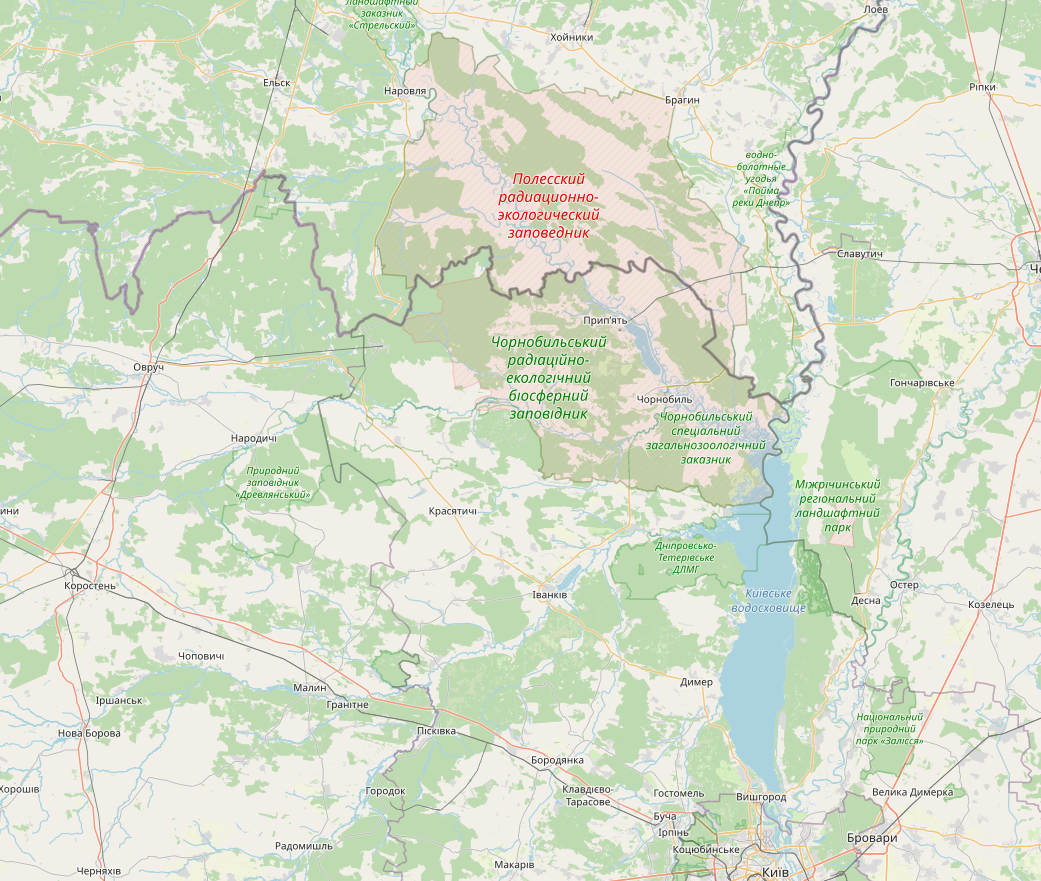

Now the next step is to cut out the bounding box of our interest from the landcover datasets
for the years 1992 to 2015.

In [12]:
bbox_landcovers = {}

for year, data_path in tqdm.notebook.tqdm(esa_cci_landcovers.items()):
    
    out_tif = GWS_DATA_DIR / "esa_cci_rois" / f"esa_cci_{year}_chernobyl.geojson"
    if os.path.exists(out_tif):
        logging.info(f"Processed data for {year} exists. Skipping")
        continue
    else:
        logging.info(f"Processing year {year}")
        
    # Crop to bbox around regions of interest
    with rasterio.open(data_path, "r") as data:
        out_img, out_transform = mask(data, shapes=bbox.geometry, crop=True)
        out_meta = data.meta.copy()
    
    # Update metadata for cropped region
    out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": CRS.from_string(WGS84)})
    
    # Write clipping to disk
    with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(out_img)
        
    bbox_landcovers[year] = (out_img, out_transform)

  0%|          | 0/24 [00:00<?, ?it/s]

INFO: Processed data for 1992 exists. Skipping
INFO: Processed data for 1993 exists. Skipping
INFO: Processed data for 1994 exists. Skipping
INFO: Processed data for 1995 exists. Skipping
INFO: Processed data for 1996 exists. Skipping
INFO: Processed data for 1997 exists. Skipping
INFO: Processed data for 1998 exists. Skipping
INFO: Processed data for 1999 exists. Skipping
INFO: Processed data for 2000 exists. Skipping
INFO: Processed data for 2001 exists. Skipping
INFO: Processed data for 2002 exists. Skipping
INFO: Processed data for 2003 exists. Skipping
INFO: Processed data for 2004 exists. Skipping
INFO: Processed data for 2005 exists. Skipping
INFO: Processed data for 2006 exists. Skipping
INFO: Processed data for 2007 exists. Skipping
INFO: Processed data for 2008 exists. Skipping
INFO: Processed data for 2009 exists. Skipping
INFO: Processed data for 2010 exists. Skipping
INFO: Processed data for 2011 exists. Skipping
INFO: Processed data for 2012 exists. Skipping
INFO: Process

In [13]:
get_byte_size(bbox_landcovers)

'64 B'

We see that only the light-weight handle to the file is loaded, not the content of the file

# 4. Calculating Fragmentation statistics

In [44]:
import warnings

# To avoid pylandstats from cluttering our screen with warnings.
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='once')

In [18]:
input_filepaths = [GWS_DATA_DIR / "esa_cci_rois" / f"esa_cci_{year}_chernobyl.geojson" for year in range(1992, 2016)]

## 4.1 Understanding Pylandstats -  Initial tests

### 4.1.1 Analysis of 2015 data in WGS84 CRS

First, let's familiarise ourselves with the pylandstats handling of geotiff data.
Specifically we want to find out how we need to handle coordinate reference systems (crs) and how large files are.

In [29]:
chernobyl_2015_wgs84 = pls.Landscape(input_filepaths[-1])

In [30]:
get_byte_size(chernobyl_2015_wgs84)  # 777 KB

'777 KB'

Ok so it seems that the Landscape object for our region of interest at $300 m$ resolution is about $ 1 MB $ heavy.   
That's quite reasonable and pretty much the size of the landscape array.

As a next step let us calculate 
- Patch metrics
- Class metrics
- Landscape metrics

#### Patch metrics (WGS84)

In [61]:
%%time
chernobyl_2015_wgs84_patch_metrics = chernobyl_2015_wgs84.compute_patch_metrics_df()

/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 16 ms, sys: 2.98 ms, total: 19 ms
Wall time: 18.1 ms


/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/pylandstats/landscape.py:896: RuntimeWarning: Class 80 has less than 2 patches. Euclidean-nearest-neighbor might contain nan values
  warnings.warn(
/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/pylandstats/landscape.py:896: RuntimeWarning: Class 201 has less than 2 patches. Euclidean-nearest-neighbor might contain nan values
  warnings.warn(


In [70]:
get_byte_size(chernobyl_2015_wgs84_patch_metrics)

'5 MB'

In [68]:
chernobyl_2015_wgs84_patch_metrics.head()

,class_val,area,perimeter,perimeter_area_ratio,shape_index,fractal_dimension,euclidean_nearest_neighbor
patch_id,,,,,,,
0,10,6.419753e-07,1.644444,2.561538e+06,5.103448,0.352150,0.005556
1,10,1.412037e-07,0.466667,3.304918e+06,3.000000,0.654739,0.006211
2,10,2.696759e-06,5.416667,2.008584e+06,8.193277,-0.167825,0.005556
3,10,1.234568e-08,0.055556,4.500000e+06,1.250000,0.950410,0.005556
4,10,1.064198e-05,27.250000,2.560615e+06,20.872340,-1.712899,0.005556


What do we see here?
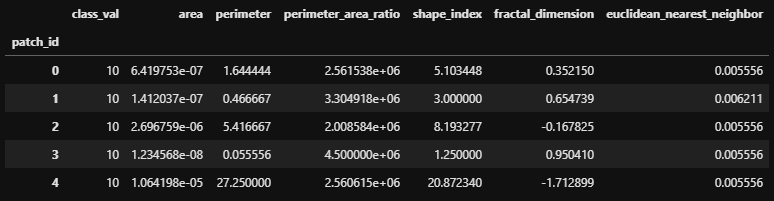

1. __Handling of CRS:__   
Seems to be problematic (see below for longer discussion).

2. __Patch IDs__:  
Interestingly, there are `patch_ids` associated with the different patches. That could be a way for us to  
reference patches with nodes in our graph. Makes me wonder whether pylandstats was thought to do something similar,  
i.e. whether it allows the identification of the geospatial position of a patch from it's ID provided that the   
original datafile is provided as well? Also, how is the ID generated? Left to right and top to bottom?

3. __Patch metrics__:
There are only a very limited number of patch metrics:
```
['class_val', 'area', 'perimeter', 'perimeter_area_ratio', 'shape_index',
       'fractal_dimension', 'euclidean_nearest_neighbor']
```

We should definitely be able to store these as the nodes of our graph.

4. __Size__:
The table of attributes seems fairly large ($5 MB$), larger than the original raster image provided. If that's true  
that might become a problem at some point.

####  Class metrics (WGS84)

Next, let's calculate the class metrics and check how long it takes.  

Timing:   
~ 4 min on Jasmin sci-8 (only 1 CPU was used - not yet sure if there's a way to spread across multiple in pylandstats).

In [36]:
%%time
chernobyl_2015_wgs84_class_metrics = chernobyl_2015_wgs84.compute_class_metrics_df()

/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 3min 49s, sys: 569 ms, total: 3min 49s
Wall time: 3min 50s


/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/pylandstats/landscape.py:912: RuntimeWarning: Class 80 has less than 2 patches. Euclidean-nearest-neighbor might contain nan values
  warnings.warn(
/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/pylandstats/landscape.py:912: RuntimeWarning: Class 201 has less than 2 patches. Euclidean-nearest-neighbor might contain nan values
  warnings.warn(
/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/pylandstats/landscape.py:912: RuntimeWarning: Class 80 has less than 2 patches. Euclidean-nearest-neighbor might contain nan values
  warnings.warn(
/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/pylandstats/landscape.py:912: RuntimeWarning: Class 201 has less than 2 patches. Euclidean-nearest-neighbor might contain nan values
  warnings.warn(
/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/pylandstats/landscape.py:912: RuntimeWarning: Class 

In [139]:
print(get_byte_size(chernobyl_2015_wgs84_class_metrics))  #  ~ 100 kB
chernobyl_2015_wgs84_class_metrics

85 KB


/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,total_area,proportion_of_landscape,number_of_patches,patch_density,largest_patch_index,total_edge,edge_density,landscape_shape_index,effective_mesh_size,area_mn,...,fractal_dimension_md,fractal_dimension_ra,fractal_dimension_sd,fractal_dimension_cv,euclidean_nearest_neighbor_mn,euclidean_nearest_neighbor_am,euclidean_nearest_neighbor_md,euclidean_nearest_neighbor_ra,euclidean_nearest_neighbor_sd,euclidean_nearest_neighbor_cv
class_val,,,,,,,,,,,,,,,,,,,,,
10,2.119282e-04,37.206382,2150,3.774566e+08,11.746753,536.522222,941924.996342,92.753098,1.387530e-05,9.857127e-08,...,0.957030,18.126582,0.493348,54.891880,0.008359,0.005909,0.006211,0.045513,0.005135,61.435949
11,3.346065e-05,5.874392,4254,7.468375e+08,0.087510,214.169444,375998.504478,92.738609,3.687460e-09,7.865691e-09,...,0.957030,0.730026,0.076833,8.229317,0.010386,0.007763,0.006211,0.113921,0.008341,80.310310
30,1.678704e-05,2.947153,5118,8.985224e+08,0.050799,149.047222,261669.132110,91.138983,6.173726e-10,3.279999e-09,...,0.973047,0.642152,0.047264,4.953543,0.012091,0.010528,0.008784,0.087282,0.008358,69.123753
40,2.805556e-06,0.492547,1548,2.717688e+08,0.003251,30.347222,53277.955687,45.190083,1.420908e-11,1.812374e-09,...,0.989369,0.187852,0.031375,3.220985,0.022281,0.021769,0.016897,0.129902,0.017815,79.955646
60,4.668904e-05,8.196786,2757,4.840223e+08,0.657813,175.000000,307232.147211,64.457317,5.816854e-08,1.693473e-08,...,0.957030,1.286746,0.084488,9.051238,0.012478,0.008236,0.008333,0.083723,0.010154,81.377210
61,1.851852e-07,0.032511,74,1.299153e+07,0.003116,1.738889,3052.814669,10.096774,1.603408e-12,2.502503e-09,...,0.989369,0.192237,0.032986,3.407472,0.101258,0.086755,0.076906,0.355823,0.098075,96.856259
70,1.479560e-04,25.975340,2416,4.241559e+08,2.599688,373.419444,655579.758441,77.122146,1.157993e-06,6.124007e-08,...,0.942163,3.178140,0.164089,18.149418,0.009441,0.006196,0.006211,0.063219,0.006581,69.702252
80,1.543210e-09,0.000271,1,1.755612e+05,0.000271,0.022222,39.013606,1.333333,4.180985e-15,1.543210e-09,...,0.937436,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
90,4.432022e-05,7.780912,3539,6.213112e+08,1.000672,240.172222,421649.300193,90.316667,7.395809e-08,1.252337e-08,...,0.937436,1.887512,0.094076,10.219451,0.010092,0.007291,0.006211,0.161204,0.008889,88.081227


What do we see here?
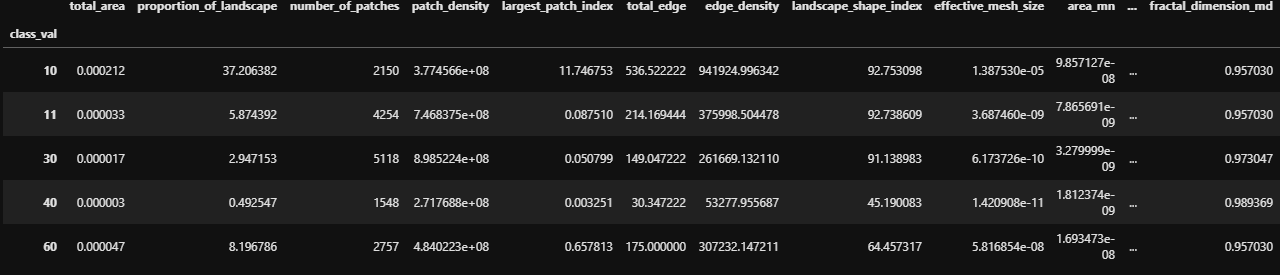

1. __Handling of CRS:__   
pylandstats seems to not have used the `crs` attribute in our `.geotif` files for the area calculations.   
At least as far as I can tell from looking at the `total_area` column, which has tiny values that cannot possibly correspond to $\text{km}^2$ or $\text{m}^2$.  
Even when summing up all values for the all classes, we get an area of only `0.00057`, while we know our bbox has about $44'000  \text{km}^2$
Instead they probably correspond to degrees squared, which is problematic because the pixel resolution for latitude & longitude pixels varies at  
different latitudes (c.f. material in Appendix).   
==> Takeaway: his mean we will have to first perform a reprojection into an appropriate `crs` before using pylandstats

2. __Filesize__:   
The output file of pylandstats has about `100 KB`.   
==> Takeaway: That's actually quite small and definitely feasible for our graphs.

3. __Computation time__:  
Executing the entire class metric analysis for our region of interest took about 4 min on 
Jasmin Sci-8 with 1 CPU.  
==> Takeaway: That seems feasible but fairly slow to me. There should definitey be a way to parallelize this computation across  
multiple cores, but as far as I understand now pylandstats does not seem to offer such an option at the moment. I contacted the   
main developer to find out.

3. __Available metrics__:  
Here's a list of all metrics we get from a pylandstats class metrics call:
```
['total_area', 'proportion_of_landscape', 'number_of_patches',
       'patch_density', 'largest_patch_index', 'total_edge', 'edge_density',
       'landscape_shape_index', 'effective_mesh_size', 'area_mn', 'area_am',
       'area_md', 'area_ra', 'area_sd', 'area_cv', 'perimeter_mn',
       'perimeter_am', 'perimeter_md', 'perimeter_ra', 'perimeter_sd',
       'perimeter_cv', 'perimeter_area_ratio_mn', 'perimeter_area_ratio_am',
       'perimeter_area_ratio_md', 'perimeter_area_ratio_ra',
       'perimeter_area_ratio_sd', 'perimeter_area_ratio_cv', 'shape_index_mn',
       'shape_index_am', 'shape_index_md', 'shape_index_ra', 'shape_index_sd',
       'shape_index_cv', 'fractal_dimension_mn', 'fractal_dimension_am',
       'fractal_dimension_md', 'fractal_dimension_ra', 'fractal_dimension_sd',
       'fractal_dimension_cv', 'euclidean_nearest_neighbor_mn',
       'euclidean_nearest_neighbor_am', 'euclidean_nearest_neighbor_md',
       'euclidean_nearest_neighbor_ra', 'euclidean_nearest_neighbor_sd',
       'euclidean_nearest_neighbor_cv']
   ```  
==> Takeaway: That's a lot of metrics, we'll have to think more about which ones we actually wish to use.

#### Landscape metrics (WGS84)

Next, let's look at the more aggregated landscape metrics

In [58]:
%%time
chernobyl_2015_wgs84_landscape_metrics = chernobyl_2015_wgs84.compute_landscape_metrics_df()

/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/pylandstats/landscape.py:896: RuntimeWarning: Class 80 has less than 2 patches. Euclidean-nearest-neighbor might contain nan values
  warnings.warn(
/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/pylandstats/landscape.py:896: RuntimeWarning: Class 201 has less than 2 patches. Euclidean-nearest-neighbor might contain nan values
  warnings.warn(


CPU times: user 2.31 s, sys: 17.9 ms, total: 2.32 s
Wall time: 2.32 s


In [60]:
chernobyl_2015_wgs84_landscape_metrics.head()

,total_area,number_of_patches,patch_density,largest_patch_index,total_edge,edge_density,landscape_shape_index,effective_mesh_size,area_mn,area_am,...,fractal_dimension_sd,fractal_dimension_cv,euclidean_nearest_neighbor_mn,euclidean_nearest_neighbor_am,euclidean_nearest_neighbor_md,euclidean_nearest_neighbor_ra,euclidean_nearest_neighbor_sd,euclidean_nearest_neighbor_cv,contagion,shannon_diversity_index
0,0.00057,31696,5.564589e+09,11.746753,1053.352778,1.849279e+06,111.32548,0.000015,1.797078e-08,0.000015,...,0.151989,16.218971,0.012724,NaN,NaN,0.692529,0.017632,NaN,52.509529,1.854107


Again we see the same problem with the area calculation. I don't see any more takeaways other than the ones  
already discussed above.

### 4.1.2 Analysis of 2015 data in UTM35 CRS

Let us now compare this to what happens if we transform our raster data to our preferred coordinate system first.
If there is a difference, that means PLS does not take care of handling coordinate systems and will simply calculate
metrics with the given coordinates. (Which means that areas will be very wrong if we use WGS84 as crs).

So let us load the rasterio data and reproject it into our `PREFERRED_CRS`

<xarray.DataArray (band: 1, y: 681, x: 1086)>
[739566 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * y            (y) float64 52.43 52.43 52.43 52.43 ... 50.55 50.55 50.55 50.55
  * x            (x) float64 28.41 28.41 28.41 28.42 ... 31.41 31.42 31.42 31.42
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

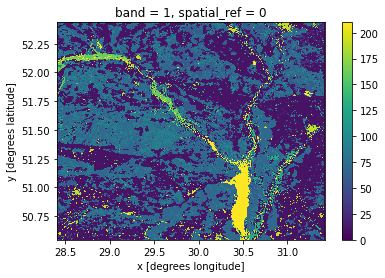

In [71]:
data_wgs84 = rxr.open_rasterio(input_filepaths[-1])
data_wgs84.x.attrs["units"] = "degrees longitude"
data_wgs84.y.attrs["units"] = "degrees latitude"
data_wgs84.plot()
data_wgs84

<xarray.DataArray (band: 1, y: 730, x: 726)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)
Coordinates:
  * x            (x) float64 5.957e+05 5.96e+05 ... 8.129e+05 8.132e+05
  * y            (y) float64 5.819e+06 5.818e+06 5.818e+06 ... 5.6e+06 5.6e+06
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref
    _FillValue:    0

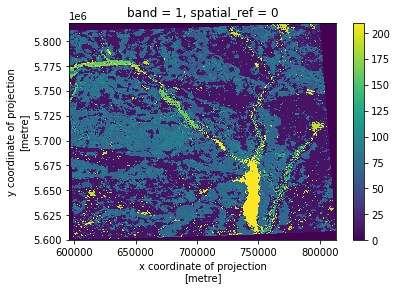

In [93]:
pixel_size = 300  # m
data_utm35 = data_wgs84.rio.reproject(PREFERRED_CRS, resolution=(pixel_size, pixel_size))
data_utm35.plot()
data_utm35

Note: Apparently the reprojected pixel resolution was resampled to ~231 m/pixel when I did not specify the resolution   
while the ESA CCI dataset claims a resoution of 300 m.   
To fix this for now, I set the resampling resolution to 300 m/pixel.  
==> QUESTION: How to understand the resolution quoted by ESA? Because their dataset is provided in WGS84, obviously  
the resolution strongly depends on where on the planet we look (e.g. at the poles, pixel will be physically much closer   
together than at the equator in WGS84 projection).

Let's briefly verify that our pixel resoution is roughly 300 m:

In [96]:
x_res = abs(data_utm35.x.data[-1] - data_utm35.x.data[0]) / len(data_utm35.x.data)
y_res = abs(data_utm35.y.data[-1] - data_utm35.y.data[0]) / len(data_utm35.y.data)
print(f"X res: {x_res:.3f} m/pixel \nY res: {y_res:.3f} m/pixel")

X res: 299.587 m/pixel 
Y res: 299.589 m/pixel


Nice, that seems to have worked out.  
Next, let's do a sanity check on the dimensions of our bounding box and its area.

In [82]:
data_utm35.shape  # size of bounding box is about 219 km by 218 km (area: 47'700 km2, slightly larger than actual boundary box due to distortion and resulting no-data values)

(1, 730, 726)

In [83]:
bbox.to_crs(PREFERRED_CRS).area / 1e6  # km2 

0    44022.31837
dtype: float64

__Note:__   
We have now reprojected our dataset from WGS84 (where the shape was 1086 by 681 pixel) to   
UTM35 at a resolution of 300 m (because that's the resolution at which we expect the ESA CCI data  
to be roughly accurate). The resulting data array in UTM35 is almost quadratic (730 by 726 pixel)  
and the size of its bounding box is about 219 km by 218 km.  
That means the area is 47'700 km2, slightly larger than the area of the actual boundary box   
around our region of interest (44'000 km2) presumably due to distortion and resulting no-data values).

Let's briefly plot the areas of interest, just to illustrate this point graphically and calculate  
the area of the no-data regions to verify the above hypothesis about the areas.

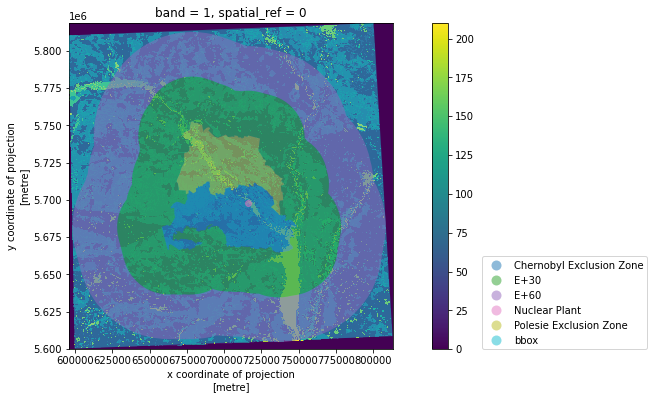

In [179]:
f, ax = plt.subplots(figsize=(14,6))

test_2015_utm35.plot(ax=ax)
rois.to_crs(PREFERRED_CRS).plot(column="name", 
                                categorical=True, 
                                legend=True, 
                                ax=ax, 
                                zorder=4, 
                                alpha=0.5)
legend = ax.get_legend()
legend.set_bbox_to_anchor((1.8,0.3))
f.show()

In [94]:
# Indeed the area of no-data values is about 3'700 km2
np.sum(data_utm35 == 0) * pixel_size**2 / 1e6  # km2 

<xarray.DataArray ()>
array(3671.55)
Coordinates:
    spatial_ref  int64 0

We see that, indeed, the area of no-data values is about 3'700 km2 which means that the area of   
our bbox in UTM35 is about 44'000 km2, as it should be.

Let us now use this reprojected array (in UTM35) in conjunction with pylandstats, just as we did   
above for the case of WGS84.

We will calculate:  
- Patch metrics
- Class metrics
- Landscape metrics

In [105]:
chernobyl_2015_utm35 = pls.Landscape(data_utm35.data.squeeze(), 
                                     res=(x_res, y_res), 
                                     nodata=0, 
                                     transform=data_utm35.rio.transform())

#### Patch metrics (UTM35)

In [106]:
%%time
chernobyl_2015_utm35_patch_metrics = chernobyl_2015_utm35.compute_patch_metrics_df()

CPU times: user 2min 28s, sys: 277 ms, total: 2min 28s
Wall time: 2min 28s


/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/pylandstats/landscape.py:896: RuntimeWarning: Class 80 has less than 2 patches. Euclidean-nearest-neighbor might contain nan values
  warnings.warn(
/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/pylandstats/landscape.py:896: RuntimeWarning: Class 201 has less than 2 patches. Euclidean-nearest-neighbor might contain nan values
  warnings.warn(


In [129]:
print(get_byte_size(chernobyl_2015_utm35_patch_metrics))
chernobyl_2015_utm35_patch_metrics.head()

4 MB


/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,class_val,area,perimeter,perimeter_area_ratio,shape_index,fractal_dimension,euclidean_nearest_neighbor
patch_id,,,,,,,
0,10,44.876458,3595.054908,80.110042,1.200005,1.045165,1339.792796
1,10,17.950583,1797.525190,100.137426,1.000003,1.009736,847.359366
2,10,5412.100787,173760.919280,32.106002,5.800020,1.199450,599.173554
3,10,26.925875,2995.881354,111.264031,1.250006,1.058702,847.359366
4,10,17.950583,2396.703272,133.516737,1.333338,1.057295,947.376572


Ok so this took about 2-3 min on Jasmin Sci-8 (again on one core). 
Interestingly though, this was about 25% faster than in the prior case where we had the data in WGS84.   
This is the bulk computation that we might want to reuse/reimplement for the case of our graph.

Again the files is roughly 4 MB in size, so about 4 times larger than the input array.

#### Class metrics (UTM35)

In [113]:
%%time
chernobyl_2015_utm35_class_metrics = chernobyl_2015_utm35.compute_class_metrics_df()

/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 4.53 s, sys: 11 ms, total: 4.54 s
Wall time: 4.54 s


/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/pylandstats/landscape.py:912: RuntimeWarning: Class 80 has less than 2 patches. Euclidean-nearest-neighbor might contain nan values
  warnings.warn(
/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/pylandstats/landscape.py:912: RuntimeWarning: Class 201 has less than 2 patches. Euclidean-nearest-neighbor might contain nan values
  warnings.warn(
/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/pylandstats/landscape.py:912: RuntimeWarning: Class 80 has less than 2 patches. Euclidean-nearest-neighbor might contain nan values
  warnings.warn(
/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/pylandstats/landscape.py:912: RuntimeWarning: Class 201 has less than 2 patches. Euclidean-nearest-neighbor might contain nan values
  warnings.warn(
/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/pylandstats/landscape.py:912: RuntimeWarning: Class 

So we see here that the class metrics (and also the landscape metrics) rely on the patch metrics to be compute.   
I.e. if we calculate the path metrics, we can easily get all the other metrics (this could be one way for us to distill some  
metrics from the graph).

In [121]:
print(get_byte_size(chernobyl_2015_utm35_class_metrics))
chernobyl_2015_utm35_class_metrics

86 KB


,total_area,proportion_of_landscape,number_of_patches,patch_density,largest_patch_index,total_edge,edge_density,landscape_shape_index,effective_mesh_size,area_mn,...,fractal_dimension_md,fractal_dimension_ra,fractal_dimension_sd,fractal_dimension_cv,euclidean_nearest_neighbor_mn,euclidean_nearest_neighbor_am,euclidean_nearest_neighbor_md,euclidean_nearest_neighbor_ra,euclidean_nearest_neighbor_sd,euclidean_nearest_neighbor_cv
class_val,,,,,,,,,,,,,,,,,,,,,
10,1.633593e+06,37.206783,2032,0.046281,12.143668,4.306620e+07,9.808777,84.875024,110925.780937,803.933469,...,1.023008,0.320094,0.047885,4.605104,840.830974,624.959670,669.896398,4080.521500,458.647692,54.546955
11,2.566844e+05,5.846254,4036,0.091924,0.117134,1.684517e+07,3.836662,83.221546,32.238706,63.598702,...,1.017146,0.223110,0.038794,3.752921,1040.895584,800.355035,669.896398,13064.085673,795.650068,76.438990
30,1.291185e+05,2.940810,4769,0.108619,0.049266,1.159521e+07,2.640929,80.850303,4.758812,27.074553,...,1.009736,0.214508,0.029854,2.917796,1185.905791,1054.700462,898.760331,7665.295713,771.029782,65.016107
40,2.182791e+04,0.497153,1349,0.030725,0.003066,2.340971e+06,0.533181,39.525402,0.122377,16.180807,...,1.000000,0.113687,0.021289,2.102734,2190.035638,2079.576982,1797.520661,10930.052908,1557.980101,71.139486
60,3.584731e+05,8.164600,2590,0.058990,0.650265,1.425644e+07,3.247052,59.925223,446.461899,138.406619,...,1.023008,0.212301,0.036412,3.519134,1204.591990,827.617553,898.760331,8959.475782,916.966896,76.122613
61,1.409121e+03,0.032094,65,0.001480,0.003680,1.330165e+05,0.030296,8.538494,0.014586,21.678781,...,1.009736,0.088737,0.023775,2.337669,9167.748853,8006.538483,8749.780457,36815.604789,7929.488806,86.493303
70,1.143335e+06,26.040659,2328,0.053023,3.952288,3.036791e+07,6.916609,71.354608,12527.058625,491.123480,...,1.026684,0.297559,0.043627,4.188864,931.593133,651.853456,669.896398,6646.863885,599.534902,64.355874
80,1.795058e+01,0.000409,1,0.000023,0.000409,2.396694e+03,0.000546,1.333338,0.000073,17.950583,...,1.057295,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
90,3.407649e+05,7.761276,3428,0.078076,1.009025,1.900069e+07,4.327606,81.577227,571.705383,99.406328,...,1.023008,0.277436,0.042111,4.055205,996.422542,750.554077,669.896398,15346.612317,810.914990,81.382642


Comparing this to the data when the utm35 conversion was not carried out (copied below),   
we see that the values are indeed different and that we should probably take care of the crs conversions ourselves -  
they seem to not be handled (at least not automatically) in pylandstats.  

More concerning is actually, that the number of patches changed in the different crs - which should technically not happen, but might be due to the resampling I applied to (300, 300) meter.

For comparison, here's what we got from the WGS84 case: 
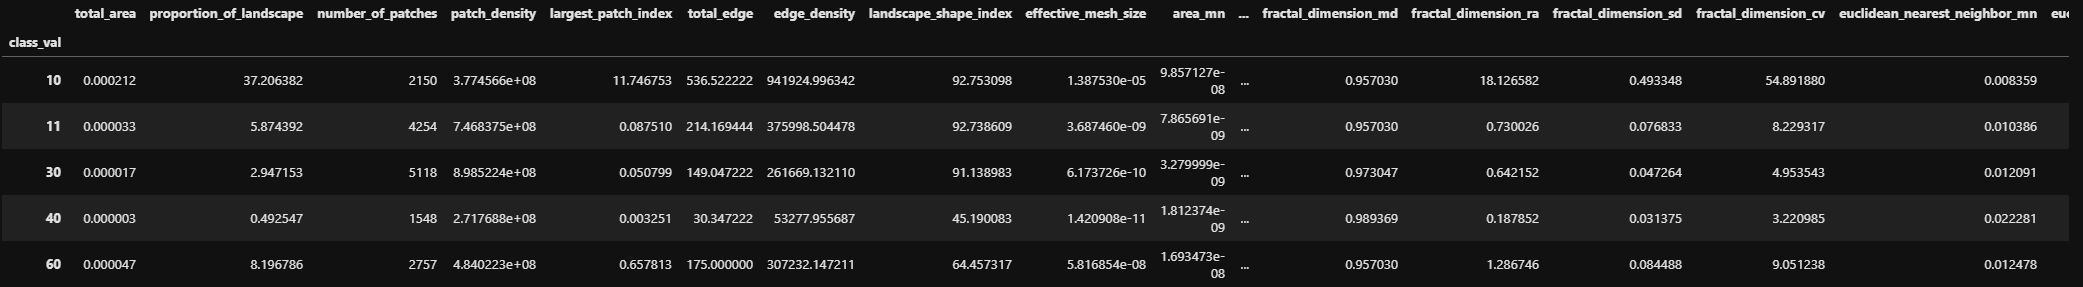


Let's look at the areas and see whether the are reasonable now that we reprojected (area units: $m^2$)

In [131]:
# Total area
chernobyl_2015_utm35_class_metrics.total_area.sum() / 1e6  # km2  (4.3905 ...)

4.390577982423866

That's weird, I would have expected a total area of roughly about 44'000 km2, but instead  
we see an area of about 4.4 km2 --> where did 4 orders of magnitude go?

I definitely don't understand the pylandstats area calculation yet. This seems fishy to me,   
something goes pretty wrong somewhere here ... 

#### Landscape metrics (UTM35)

In [132]:
%%time
chernobyl_2015_utm35_landscape_metrics = chernobyl_2015_utm35.compute_landscape_metrics_df()

/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/pylandstats/landscape.py:896: RuntimeWarning: Class 80 has less than 2 patches. Euclidean-nearest-neighbor might contain nan values
  warnings.warn(
/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/pylandstats/landscape.py:896: RuntimeWarning: Class 201 has less than 2 patches. Euclidean-nearest-neighbor might contain nan values
  warnings.warn(


CPU times: user 2.4 s, sys: 15 ms, total: 2.41 s
Wall time: 2.41 s


In [137]:
print(get_byte_size(chernobyl_2015_utm35_landscape_metrics))
chernobyl_2015_utm35_landscape_metrics.head()

65 KB


/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,total_area,number_of_patches,patch_density,largest_patch_index,total_edge,edge_density,landscape_shape_index,effective_mesh_size,area_mn,area_am,...,fractal_dimension_sd,fractal_dimension_cv,euclidean_nearest_neighbor_mn,euclidean_nearest_neighbor_am,euclidean_nearest_neighbor_md,euclidean_nearest_neighbor_ra,euclidean_nearest_neighbor_sd,euclidean_nearest_neighbor_cv,contagion,shannon_diversity_index
0,4.390578e+06,29697,0.67638,12.143668,8.406045e+07,19.145647,101.320607,125812.149071,147.845842,125812.149071,...,0.037641,3.65091,1239.200643,NaN,NaN,76432.50427,1627.84416,NaN,51.195929,1.853364


# A) Appendix

## A1) Estimating the error from a spherical approximation of the area

Since the earth is neither a sphere and nor a proper ellipsoid, the area computed from a well projected map will be 
different from the area computed from latitude and longitude values under the assumption of a sphere.

Let us briefly estimate that error with the example of the bounding box of chernobyl

In [234]:
def sphere_area(x_max, x_min, y_max, y_min, r=1.):
    
    delta_phi = 2 * np.pi * (x_max - x_min)/360
    
    theta_max = np.pi * (y_max+90) / 180
    theta_min = np.pi * (y_min+90) / 180
    
    return (delta_phi) * (np.cos(theta_min) - np.cos(theta_max)) * r**2

In [237]:
assert np.allclose(sphere_area(180, -180, 90, -90, r=1), 4*np.pi)

In [244]:
true_area = bbox.to_crs(PREFERRED_CRS).area / 1e6

In [245]:
sphere_approx_area = sphere_area(maxx, minx, maxy, miny, r=6.371*1e3)

In [252]:
abs(true_area - sphere_approx_area) / true_area * 100  # difference: 0.37 % (=164 km2)

0    0.373922
dtype: float64

Seems that the area computations for our region of interest will have an error of around $0.5 \% $ if we calculate them under the assumption
of a spherical earth.

## A2) Understanding ESA CCI pixel resolution at different latitudes and longitudes
How does the length of longitudes/latitudes change from equator to pole?
[Source](https://calgary.rasc.ca/latlong.htm)

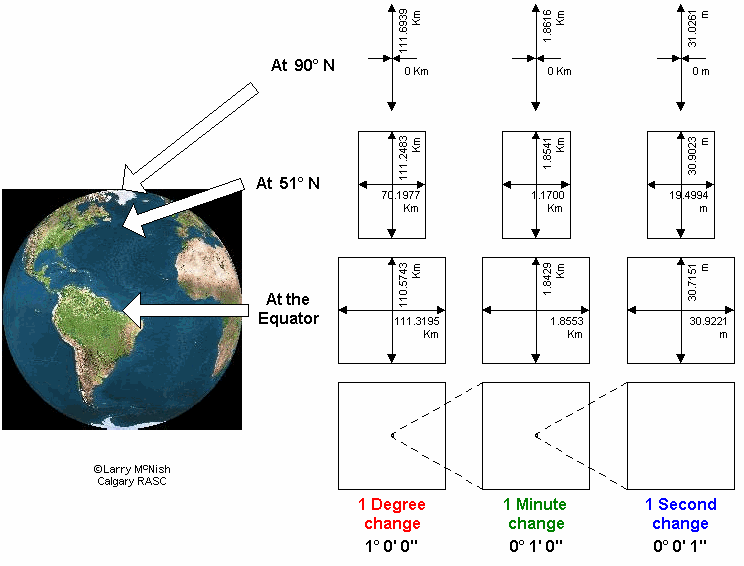
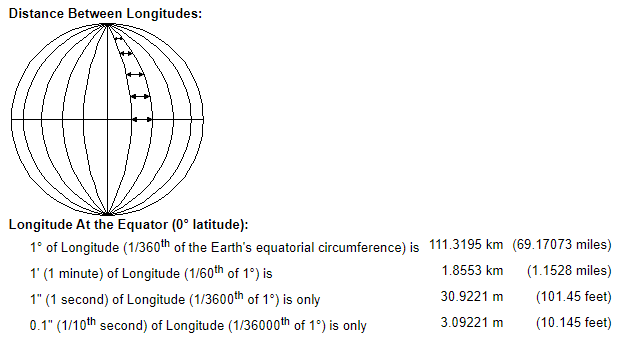
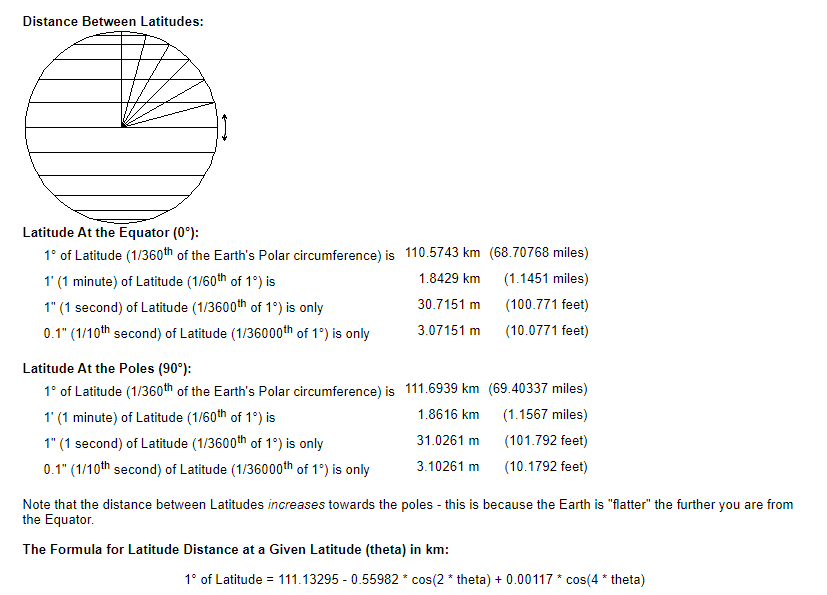

So roughly, what is the resolution of the ESA CCI landcover dataset at the equator?

In [274]:
40000 * 1e3 / 129600  # At equator, the circumference is 40'000 km. We have 129'600 pixels at that width --> max possible resolution is 309 m 

308.641975308642

Ok so at the equator the ESA CCI Raster data has a resolution of 309 m per pixel. 
This is at least somewhat in line with their announcement of a "resolution of 300m".

However, since the data is stored in raster format, there are always the same amount of pixels for each longitude at each latitude. Physically then, longitude pixels at higher latitude correspond to a higher resolution (less meter per pixel).

Let's roughly estimate the effect for our case of about 51 deg latitude

In [26]:
# Calculate ESA CCI resolution at 51 degree latitude (in longitudinal direction):
# Note: 70.1977 km is the length of 1 deg longitude at 51 deg latitude. 
# Note: 1086 is the number of pixel at our area of interest
km_per_longitude_at_51_latitude = 70.1977

(maxx - minx) * km_per_longitude_at_51_latitude / 1086 * 1e3  # 194.7 m
# --> ESA CCI seems to have a resolution of 194.7m per pixel (longitudinal direction)
#     at 51 degree latitude.

194.6941938040678

Ok seems like we get a resolution somewhere around 194.6 m per pixel from the ESA CCI raster data.
The question is now, is this the actual resolution or was this down/upsampled? Was it e.g. upsampled from the 300m resolution? What does ESA mean by 300m resolution landcover dataset?

In [34]:
# What is the variation over our area of interest?
def longitude_at_theta(theta):
    
    theta_rad = theta*np.pi / 180
    
    return 111.41288 * np.cos(theta_rad) - 0.09350 * np.cos(3 * theta_rad) + 0.00012 * np.cos(5 * theta_rad)

length_diff_across_bbox = longitude_at_theta(miny) - longitude_at_theta(maxy)
length_diff_across_bbox  # km

2.8738625748443383

In [38]:
mean_length_bbox = longitude_at_theta((maxy + miny) / 2)

print(f"Relative longitudinal length change across bbox: {length_diff_across_bbox/mean_length_bbox*100:.2f}%")

Relative longitudinal length change across bbox: 4.14%


In [39]:
# Highest resolution:
# at highest latitude:
(maxx - minx) * longitude_at_theta(maxy) / 1086 * 1e3  # 188.6 m

188.62354643771314

In [41]:
# Lowest resolution:
# at lowest latitude
(maxx - minx) * longitude_at_theta(miny) / 1086 * 1e3  # 196.6 m

196.5942400233007

Unfortunately, pylandstats does not seem to handle these auttomatically. So it seems that we have to deal with reprojections ourselves.